In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from load import load_dataset
from model import CNN

Загрузка датасета

In [2]:
train_dir_path = "bird_dataset/train/"
test_dir_path = "bird_dataset/test/"
image_size = 160

train = load_dataset(train_dir_path, image_size)
test = load_dataset(test_dir_path, image_size)
print(train)

Dataset ImageFolder
    Number of datapoints: 1331
    Root location: bird_dataset/train/
    StandardTransform
Transform: Compose(
               Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [3]:
bs = 32
train_loader = torch.utils.data.DataLoader(train, batch_size=bs)
test_loader = torch.utils.data.DataLoader(test, batch_size=bs)

In [4]:
train_labels = []
for _, labels in train_loader:
    train_labels.extend(labels.numpy())
all_labels = torch.tensor(train_labels)
label_counts = torch.bincount(all_labels)
print(label_counts.tolist())

[208, 216, 165, 178, 208, 193, 163]


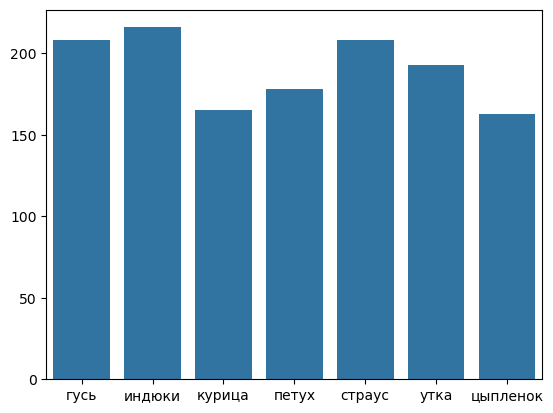

In [5]:

sns.barplot(x=train_loader.dataset.classes, y=label_counts.tolist() )
plt.show()

In [6]:
test_labels = []
for _, labels in test_loader:
    test_labels.extend(labels.numpy())
all_labels = torch.tensor(test_labels)
label_counts = torch.bincount(all_labels)
print(label_counts.tolist())

[40, 40, 40, 40, 40, 40, 40]


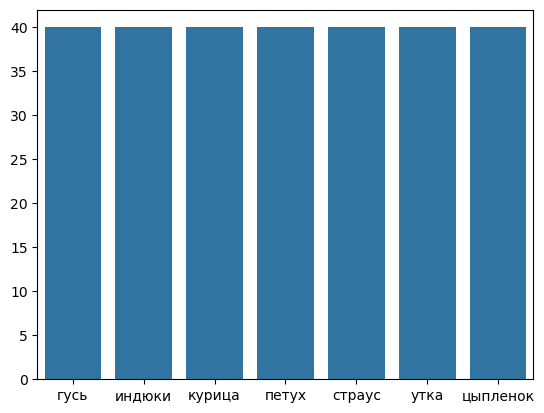

In [7]:
sns.barplot(x=train_loader.dataset.classes, y=label_counts.tolist() )
plt.show()

Подсчёт размера для слоя fc1

In [8]:
160 / 4 / 4

10.0

In [9]:
model = CNN()

model.fc2.bias.data.fill_(0)
model.fc2.weight.data *= 0.001

Подсчёт ошибки на первой эпохе (при случайном выборе класса)

In [10]:
-torch.tensor(1/7).log()

tensor(1.9459)

Обучение

In [11]:
num_epochs = 40
learning_rate = 0.001

x = [epoch for epoch in range(0, num_epochs)]
y = []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_f = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_f(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss = running_loss / len(train_loader)
    y.append(loss)
    print(f'epoch: {epoch+1}/{num_epochs}, loss: {loss}')


epoch: 1/40, loss: 2.7429886923304627
epoch: 2/40, loss: 2.151482345092864
epoch: 3/40, loss: 2.0616206441606795
epoch: 4/40, loss: 2.003962508269719
epoch: 5/40, loss: 2.0491183002789817
epoch: 6/40, loss: 2.010523270993006
epoch: 7/40, loss: 1.9557545468920754
epoch: 8/40, loss: 1.9551802618162972
epoch: 9/40, loss: 1.8616417192277455
epoch: 10/40, loss: 1.8157389334269933
epoch: 11/40, loss: 1.7998754722731454
epoch: 12/40, loss: 1.6770962079366047
epoch: 13/40, loss: 1.5763619882719857
epoch: 14/40, loss: 1.4808299839496613
epoch: 15/40, loss: 1.4242482852368128
epoch: 16/40, loss: 1.3962832873775846
epoch: 17/40, loss: 1.3003712367443812
epoch: 18/40, loss: 1.243733061921029
epoch: 19/40, loss: 1.1301707511856443
epoch: 20/40, loss: 1.0806861051491328
epoch: 21/40, loss: 1.0202769693874179
epoch: 22/40, loss: 0.9579522276208514
epoch: 23/40, loss: 0.8773896091041111
epoch: 24/40, loss: 0.8023319989442825
epoch: 25/40, loss: 0.7629452993472418
epoch: 26/40, loss: 0.7816771659113112

Без исправления ошибки на 1 эпохе

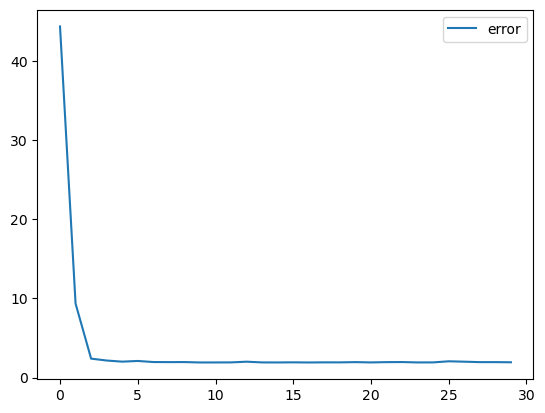

In [17]:
plt.plot(x, y, label='error')
plt.legend()
plt.show()

После

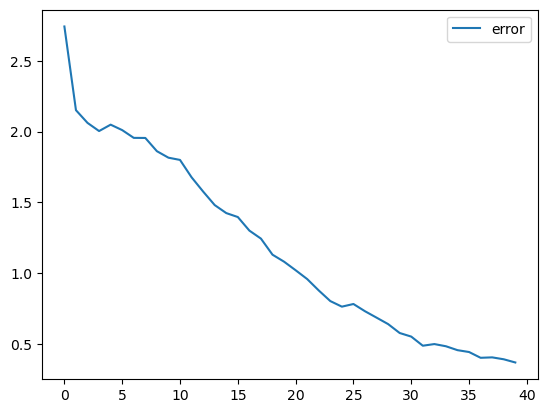

In [12]:
plt.plot(x, y, label='error')
plt.legend()
plt.show()

In [15]:
torch.save(model.state_dict(), "model_weights.pth")

Оценка модели

In [13]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())


Отчёт о модели

In [14]:
report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
print(report)

              precision    recall  f1-score   support

        гусь       0.97      0.95      0.96        40
      индюки       1.00      0.97      0.99        40
      курица       0.97      0.95      0.96        40
       петух       0.93      1.00      0.96        40
      страус       1.00      0.95      0.97        40
        утка       0.90      0.95      0.93        40
    цыпленок       1.00      1.00      1.00        40

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280



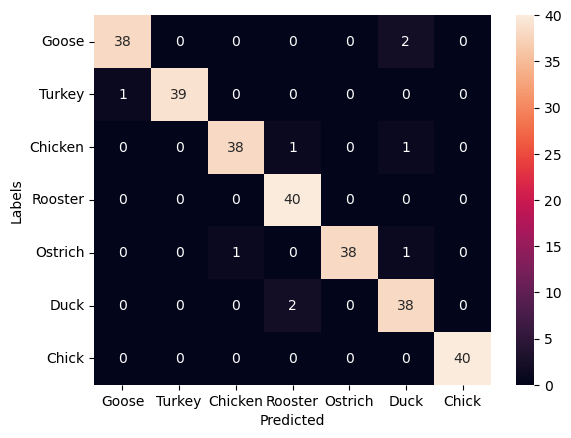

In [16]:
cm = confusion_matrix(all_labels, all_preds)

sns.heatmap(cm, annot=True,
            xticklabels=['Goose', 'Turkey', 'Chicken', 'Rooster', 'Ostrich', 'Duck', 'Chick'],
            yticklabels=['Goose', 'Turkey', 'Chicken', 'Rooster', 'Ostrich', 'Duck', 'Chick']
            )

plt.ylabel('Labels')
plt.xlabel('Predicted')
plt.show()

In [21]:
model = CNN()
model.load_state_dict(torch.load("model_weights.pth"))

C:\Users\alexa\AppData\Local\Temp\ipykernel_3316\2954526511.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth"))


<All keys matched successfully>